In [1]:
import os
import re
import imageio
import numpy as np
from importlib import reload
from gymnasium import spaces
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env
import Agents.utils.stats_functions as sf
from Agents.utils.actions import MORE_ACTIONS
from Agents.Random.random_agent import RandomAgent
from Agents.Pablo.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN

ModuleNotFoundError: No module named 'Agents'

In [5]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 +  563 *i for i in range(1000)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = False

In [ ]:
reload(h_env)
agent1_name = "Dueling-Double-DQN"

env_name = "../last_chance/Hockey/Dueling_Double_DQN"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Hidden Layer 3: Linear(256, 128) -> Tanh
  Value Stream: Linear(128, 1)
  Advantage Stream: Linear(128, 7)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Hidden Layer 3: Linear(256, 128) -> Tanh
  Value Stream: Linear(128, 1)
  Advantage Stream: Linear(128, 7)
------------------------------------------------------
Network loaded from ../last_chance/Hockey/Dueling_Double_DQN/weights/episode_90000.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/src/hockey-env/Agents/Pablo/Adaptative_Dueling_Double_DQN/QFunction.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

In [ ]:
def test_agent(agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  
    games_won = 0
    games_lost = 0

    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
        env.action_space.seed(seed = SEEDS_TEST[episode])
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, info = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        result = info["winner"]

        if info["winner"] == 1:
            games_won += 1
        elif info["winner"] == -1:
            games_lost += 1

        test_rewards.append(total_reward)
        print(f"Test Episode {episode+1}, Total Reward: {total_reward} - Winner: {result}")
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    print(f"Winrate: {games_won}/{games_lost}: {games_won/(games_won+games_lost)} ({test_episodes - games_won - games_lost})")

    env.close()

    return games_won/(games_won+games_lost)

In [8]:
action_space = spaces.Discrete(len(MORE_ACTIONS))
agent1 = Adaptative_Dueling_Double_DQN(
    state_space,
    action_space,
    seed=seed,
    eps=0.01,
    learning_rate=0.0001,
    hidden_sizes=[256, 256],
    n_steps=5,
    use_more_actions=True,
    env=env,
    use_noisy=False,
    use_dueling = False,
    use_double = False
)

action_space = env.discrete_action_space
agent2 = Adaptative_Dueling_Double_DQN(
    state_space,
    action_space,
    seed=seed,
    eps=0.01,
    learning_rate=0.0001,
    hidden_sizes=[256, 256, 128],
    n_steps=5,
    use_more_actions=USE_MORE_ACTIONS,
    env=env,
    use_noisy=False
)

Standard Feedforward Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Output Layer: Linear(256, 20)
------------------------------------------------------
Standard Feedforward Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Output Layer: Linear(256, 20)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Hidden Layer 3: Linear(256, 128) -> Tanh
  Value Stream: Linear(128, 1)
  Advantage Stream: Linear(128, 7)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Hidden Layer 3: Linear(256, 128) -> Tanh
  Value Stream: Linear(128, 1)
  Advantage Stream: Linear(128, 7)
-------

In [9]:
agents_names = ["DQN", "Dueling_Double_DQN"]
agents = [agent1, agent2]
episode_pattern = re.compile(r'episode_(\d+)')

agents_rewards = {agent: {"episodes": [], "winrates": []} for agent in agents_names}


for i in range(len(agents)):
    stats_dir = f"../last_chance/Hockey/{agents_names[i]}/weights"
    if not os.path.exists(stats_dir):
        continue
    
    pkl_files = sorted(
        [f for f in os.listdir(stats_dir) if f.startswith("episode_") and f.endswith(".pth")],
        key=lambda x: int(episode_pattern.search(x).group(1))
    )
        
    for file_name in pkl_files:

        print(f"Agent: {agents_names[i]} - Episode: {file_name}")
        episode_number = int(episode_pattern.search(file_name).group(1))
        print(episode_number)

        agents[i].Q.load(stats_dir.removesuffix("/weights"), name = file_name.removesuffix(".pth"))

        agents_rewards[agents_names[i]]["episodes"].append(episode_number)
        agents_rewards[agents_names[i]]["winrates"].append(test_agent(agent_name = agent1_name, agent = agents[i]))

print(agents_rewards)

Agent: DQN - Episode: episode_25000.pth
25000
Network loaded from ../last_chance/Hockey/DQN/weights/episode_25000.pth
Test Episode 1, Total Reward: 9.767310121288844 - Winner: 1
Test Episode 2, Total Reward: 8.968132705653604 - Winner: 1
Test Episode 3, Total Reward: 9.773904068079275 - Winner: 1
Test Episode 4, Total Reward: -13.483135609400653 - Winner: -1
Test Episode 5, Total Reward: 0.0 - Winner: 0
Test Episode 6, Total Reward: -12.249415700406784 - Winner: -1
Test Episode 7, Total Reward: 0.0 - Winner: 0
Test Episode 8, Total Reward: 8.816474073181306 - Winner: 1
Test Episode 9, Total Reward: -3.013297504121831 - Winner: 0
Test Episode 10, Total Reward: 8.009797423535499 - Winner: 1
Test Episode 11, Total Reward: 7.218128211803307 - Winner: 1
Test Episode 12, Total Reward: 8.086061050367888 - Winner: 1
Test Episode 13, Total Reward: 0.0 - Winner: 0
Test Episode 14, Total Reward: -12.401407987959821 - Winner: -1
Test Episode 15, Total Reward: 8.860933469760283 - Winner: 1
Test Epi

In [11]:
stats, losses = sf.load_stats("../last_chance/Hockey/Tournament")
match_history = sf.load_match_history("../last_chance/Hockey/Tournament")

Plot saved at ../last_chance/Hockey/hockey_left.png


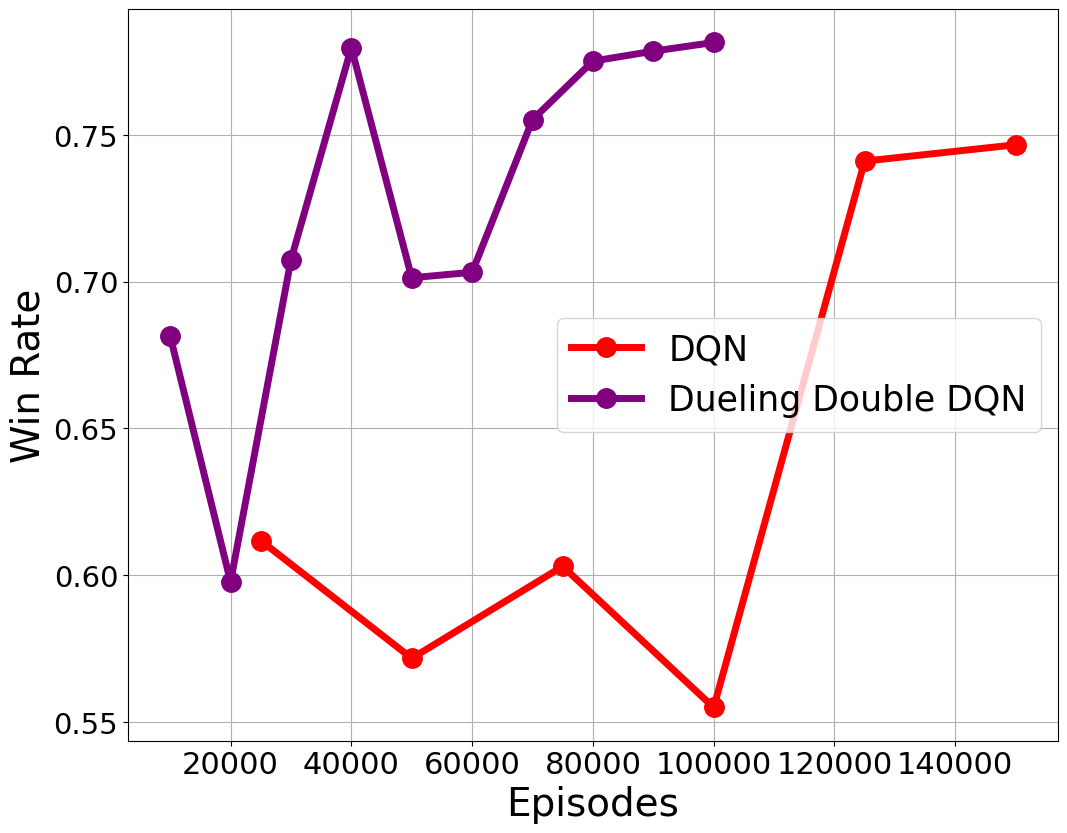

Plot saved at ../last_chance/Hockey/hockey_right.png


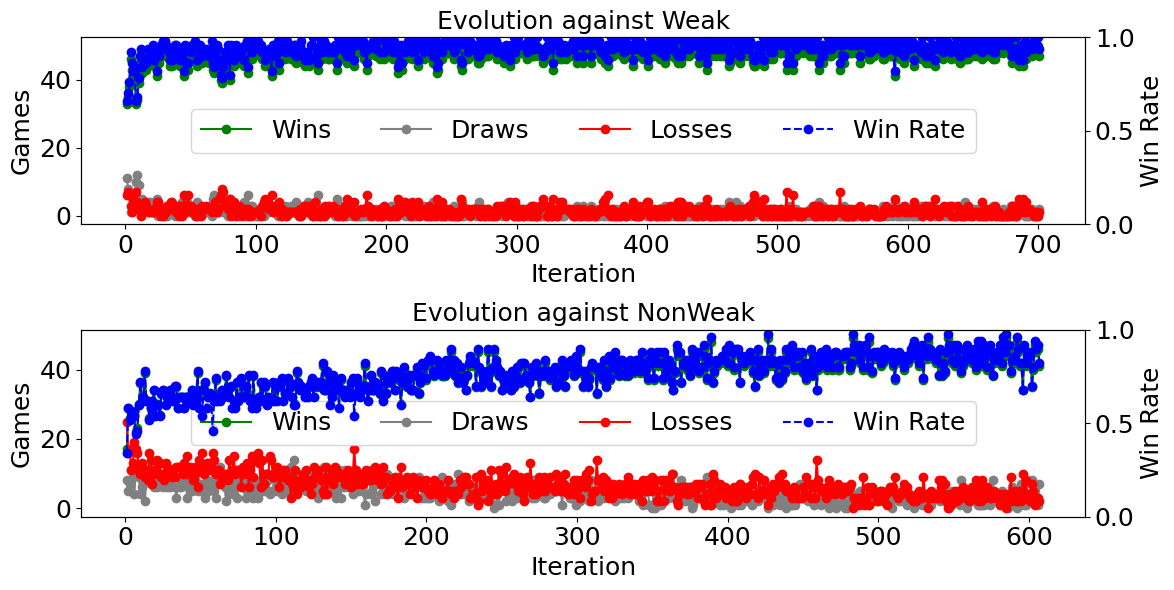

In [ ]:
def _save_plot(env_name, name):
    plot_dir = f"{env_name}"
    os.makedirs(plot_dir, exist_ok=True)
    plot_path = os.path.join(plot_dir, f"{name}.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Plot saved at {plot_path}")

def plot_match_evolution_by_chunks(env_name, match_history, opponents_names, chunk_size, name="match_evolution", save_figure=True):
    filtered_opponents = [name for name in opponents_names if name in ["Weak", "NonWeak"]]
    n_opponents = len(filtered_opponents)
    
    fig, axes = plt.subplots(n_opponents, 1, figsize=(12, 6), sharex=False)
    if n_opponents == 1:
        axes = [axes]
        
    for i, opponent in enumerate(filtered_opponents):
        results = match_history[opponents_names.index(opponent)]
        ax = axes[i]
        if len(results) == 0:
            ax.set_title(f"{opponent} (no games played)")
            continue
        
        chunks = [results[j:j+chunk_size] for j in range(0, len(results), chunk_size)]
        chunk_indices = np.arange(1, len(chunks) + 1)
        
        win_rates, wins_chunk, draws_chunk, losses_chunk = [], [], [], []
        
        for chunk in chunks:
            wins = chunk.count(1)
            draws = chunk.count(0)
            losses = chunk.count(-1)
            total = wins + draws + losses
            wr = wins / total if total > 0 else 0
            win_rates.append(wr)
            wins_chunk.append(wins)
            draws_chunk.append(draws)
            losses_chunk.append(losses)
        
        ax.plot(chunk_indices, wins_chunk, marker="o", label="Wins", color="green")
        ax.plot(chunk_indices, draws_chunk, marker="o", label="Draws", color="gray")
        ax.plot(chunk_indices, losses_chunk, marker="o", label="Losses", color="red")
        ax.set_xlabel("Iteration", fontsize=18)
        ax.set_ylabel("Games", fontsize=18)
        ax.set_title(f"Evolution against {opponent}", fontsize=18)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        
        ax2 = ax.twinx()
        ax2.plot(chunk_indices, win_rates, marker="o", linestyle="--", label="Win Rate", color="blue")
        ax2.set_ylabel("Win Rate", fontsize=18)
        ax2.set_ylim(0, 1)
        ax2.tick_params(axis='y', labelsize=18)
        
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="center", ncol=4, fontsize = 18)

    fig.tight_layout()
    _save_plot("../last_chance/Hockey", "hockey_right")

fig, ax1 = plt.subplots(figsize=(12, 9.5))
colors = {'DQN': 'red', 'Dueling_Double_DQN': 'purple'}

for agent, data in agents_rewards.items():
    ax1.plot(data['episodes'], data['winrates'], marker='o', linestyle='-', label=agent.replace("_", " "), color=colors[agent], linewidth=5, markersize = 14)

ax1.set_xlabel("Episodes", fontsize=28)
ax1.set_ylabel("Win Rate", fontsize=28)

ax1.legend(fontsize=25)
ax1.grid(True)

plt.xticks(fontsize=22)
plt.yticks(fontsize=21)
_save_plot("../last_chance/Hockey", "hockey_left")
plt.show()

plot_match_evolution_by_chunks("../last_chance/Hockey/Tournament", match_history, ["Random", "Weak", "NonWeak"], 50, save_figure=False)
